# Training model

__Task:__ Classify toxic comments.

__Used dataset:__ Small dataset (14.412 unique values) with labeled comments from 2ch.hk and pikabu.ru

Downloaded from here: https://www.kaggle.com/blackmoon/russian-language-toxic-comments

__Simple baseline__: In this project used simple baseline of training model with minimal data prepearing

### Import libraries and load data

In [2]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score, roc_auc_score, precision_score, recall_score, precision_recall_curve, confusion_matrix
import itertools
import dill

import matplotlib.pyplot as plt 

from moduls.loaders import ColumnSelector, NumberSelector, OHEEncoder #our modul

%matplotlib inline

In [3]:
df = pd.read_csv("../data_example/labeled.csv")
df.head(10)

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0
5,Для каких стан является эталоном современная с...,1.0
6,В шапке были ссылки на инфу по текущему фильму...,0.0
7,УПАД Т! ТАМ НЕЛЬЗЯ СТРОИТЬ! ТЕХНОЛОГИЙ НЕТ! РА...,1.0
8,"Ебать тебя разносит, шизик.\n",1.0
9,"Обосрался, сиди обтекай\n",1.0


Look at proportion of classes toxic and untoxic

In [4]:
df['toxic'].value_counts(normalize=True)

0.0    0.66514
1.0    0.33486
Name: toxic, dtype: float64

### Prepare data and fit model

In [5]:
X_train, X_test, y_train, y_test = train_test_split(df, df['toxic'], random_state=0, test_size=0.3)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10088, 2), (4324, 2), (10088,), (4324,))

In [6]:
#make simple pipeline
pipeline = Pipeline([('text_selector', ColumnSelector(key='comment')), 
                     ('text_tfidf', TfidfVectorizer()), 
                     ('clf', LogisticRegression())
                    ])

In [7]:
#fit model
pipeline.fit(X_train, y_train)

Pipeline(steps=[('text_selector', ColumnSelector(key='comment')),
                ('text_tfidf', TfidfVectorizer()),
                ('clf', LogisticRegression())])

In [8]:
#predicts for test dataset
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.09775112, 0.35012071, 0.0852716 , 0.1150167 , 0.22443554,
       0.09847874, 0.1512683 , 0.72443342, 0.27880936, 0.47634324])

### Evaluate model and calculate best probability threshold

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

In [10]:
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
best_threshold = thresholds[ix]
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.367991, F-Score=0.792, Precision=0.791, Recall=0.792


In [11]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[2599  298]
 [ 298 1129]]


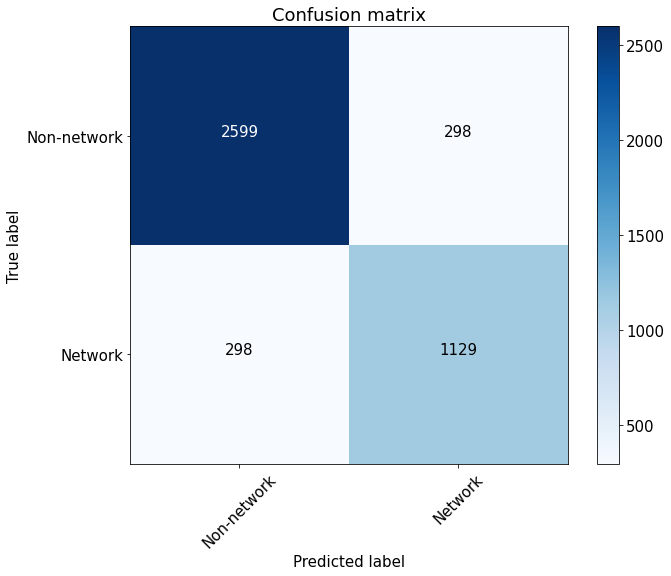

In [12]:
#use finded best threshold
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>best_threshold)
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['Non-network', 'Network'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [13]:
#get class labels
def get_class(x, threshold):
    return 1 if x > threshold else 0
vec_get_class = np.vectorize(get_class)

y_pred = vec_get_class(preds, best_threshold)
y_pred[:10]

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

### Pack model to wrapper class for comfortable use in production

In [41]:
class Logres_model:
    """
    This is class-wrapper for more comfortable using model in production:
    """

    def __init__(self, model, threshold):
        self.model = model
        self.threshold = threshold

        
    def predict(self, X_test):   
        from numpy import vectorize
        def get_class(x, threshold):
            return 1 if x > threshold else 0
        vec_get_class = vectorize(get_class)
        
        preds_proba = self.model.predict_proba(X_test)[:,1]             
        return vec_get_class(preds_proba, self.threshold)
     
    
    def predict_proba(self, X_test):
        return self.model.predict_proba(X_test)[:,1]
    
    
    def get_probability_threshold(self):
        return self.threshold

In [42]:
model = Logres_model(pipeline, best_threshold)

In [43]:
model.predict_proba(X_test)[:10]

array([0.09775112, 0.35012071, 0.0852716 , 0.1150167 , 0.22443554,
       0.09847874, 0.1512683 , 0.72443342, 0.27880936, 0.47634324])

In [44]:
y_preds = model.predict(X_test)[:10]
y_preds

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 1])

In [45]:
model.get_probability_threshold()

0.3679905070066962

### Results

In [46]:
#calculate scores
def evaluate_results(y_test, y_predict, threshold):
    print('Classification results:')
    print('proba threshold: %.3f' % (threshold))
    f1 = f1_score(y_test, y_predict,)
    print("f1: %.2f%%" % (f1 * 100.0)) 
    roc = roc_auc_score(y_test, y_predict)
    print("roc: %.2f%%" % (roc * 100.0)) 
    rec = recall_score(y_test, y_predict, average='binary', )
    print("recall: %.2f%%" % (rec * 100.0)) 
    prc = precision_score(y_test, y_predict, average='binary')
    print("precision: %.2f%%" % (prc * 100.0)) 
    
evaluate_results(y_test, y_pred, best_threshold)

Classification results:
proba threshold: 0.368
f1: 79.12%
roc: 84.42%
recall: 79.12%
precision: 79.12%


### Save model

In [47]:
with open("../app/models/logreg_model.dill", "wb") as f:
    dill.dump(model, f)